In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import random
from scipy.integrate import quad
from scipy.interpolate import interp1d
import time

# Particle Class

In [33]:
# constants 
NUM_PARTICLES = 100
PEAK_SPEED = 220  # km/s
VMAX = 500  # km/s
RMIN = 0.1  # kpc
RMAX = 100  # kpc
MASS = 1  # M_sun
G = 4.302e-6 # kpc / M_sun (km/s)^2
# V_circular = 220  # km/s, circular speed for the Milky Way
rho_0 = 0.1  # Example central density in M_sun / kpc^3
rs = 20  # Scale radius in kpc
kB = 1.0

# particle class
class Particle:
    def __init__(self, mass, position, velocity):
        self.mass = mass 
        self.position = np.array(position, dtype=float) 
        self.velocity = np.array(velocity, dtype=float)
        self.force = np.zeros_like(self.position)
        self.acceleration = np.zeros_like(self.position)


    def scattering_probability(self, other_particle):
        # cross section
        self.cross_section = 10
        return self.cross_section


# Initial Conditions

In [34]:
# Maxwell-Boltzmann distribution
def maxwell_boltzmann(v, mass=1.0, peak_speed=220.0):
    """ Maxwell-Boltzmann distribution with peak speed."""
    temperature = mass * peak_speed**2 / (2 * kB)
    prefactor = (mass / (2 * np.pi * kB * temperature)) ** (3/2)
    return prefactor * np.exp(-(mass * v**2) / (2 * kB * temperature)) * 4 * np.pi * v**2

# Sample from the Maxwell-Boltzmann distribution
def maxwell_boltzmann_samples(mass, peak_speed, num_samples, vmax=VMAX):
    """Generate samples from the Maxwell-Boltzmann distribution."""
    v = np.linspace(0, vmax, num_samples)
    # generate pdf 
    pdf = lambda v: maxwell_boltzmann(v, mass=mass, peak_speed=peak_speed)
    # generate cdf
    cdf = np.zeros(num_samples)
    for i in range(1, num_samples):
        cdf[i] = quad(lambda x: pdf(x), 0, v[i])[0]
    cdf /= cdf[-1]  # Normalize the CDF
    # generate inverse cdf
    inverse_cdf = interp1d(cdf, v, bounds_error=False, fill_value=(v[0], v[-1]))
    # generate samples
    samples = inverse_cdf(np.random.uniform(0, 1, num_samples))
    return samples

# NFW density profile
def nfw_density(r):
    """NFW profile density function."""
    x = r / rs
    return rho_0 / (x * (1 + x)**2)

def nfw_samples(rmin, rmax, num_samples):
    """Generate samples from the NFW density profile."""
    r = np.linspace(rmin, rmax, num_samples)
    # generate pdf
    pdf = lambda r: nfw_density(r)
    # generate cdf
    cdf = np.zeros(num_samples)
    for i in range(1, num_samples):
        cdf[i] = quad(lambda x: 4 * np.pi * x**2 * pdf(x), 0, r[i])[0]
    cdf /= cdf[-1]  # Normalize the CDF
    # generate inverse cdf
    inverse_cdf = interp1d(cdf, r, bounds_error=False, fill_value=(r[0], r[-1]))
    # generate samples
    samples = inverse_cdf(np.random.uniform(0, 1, num_samples))
    return samples

def starting_positions(rmin=0.001, rmax=100, num_particles=NUM_PARTICLES):
    """Generate starting positions based on the given density function."""
    radii = nfw_samples(rmin, rmax, num_particles)
    
    # Convert spherical coordinates to Cartesian coordinates
    theta = np.random.uniform(0, 2*np.pi, num_particles)
    x = radii * np.cos(theta)
    y = radii * np.sin(theta)
    
    positions = np.vstack((x, y)).T
    return positions

def starting_velocities(mass=1.0, peak_speed=220, num_particles=NUM_PARTICLES):
    """Generate starting velocities based on a given velocity distribution function."""
    speeds = maxwell_boltzmann_samples(mass, peak_speed, num_particles)

    # Assign random directions
    angles = np.random.uniform(0, 2 * np.pi, num_particles)
    vx = speeds * np.cos(angles)
    vy = speeds * np.sin(angles)

    velocities = np.vstack((vx, vy)).T
    return velocities

# def starting_velocities_rotational(position, base_speed=10.0, speed_variation=1.0):
#     theta = np.arctan2(position[1], position[0])
#     speed = base_speed + np.random.uniform(-speed_variation, speed_variation)
#     velocity = speed * np.array([-np.sin(theta), np.cos(theta)])
#     return velocity

def initialize_particles():
    positions = starting_positions(rmin=RMIN, rmax=RMAX, num_particles=NUM_PARTICLES)
    velocities = starting_velocities(mass=MASS, peak_speed=PEAK_SPEED, num_particles=NUM_PARTICLES)
    # velocities = [starting_velocities_rotational(position) for position in positions]
    particles = [Particle(1.0, position, velocity) for position, velocity in zip(positions, velocities)]
    return particles

# Example usage
start = time.time()
particles = initialize_particles()
print("Time taken: ", time.time() - start)

Time taken:  0.018499135971069336


## Checks

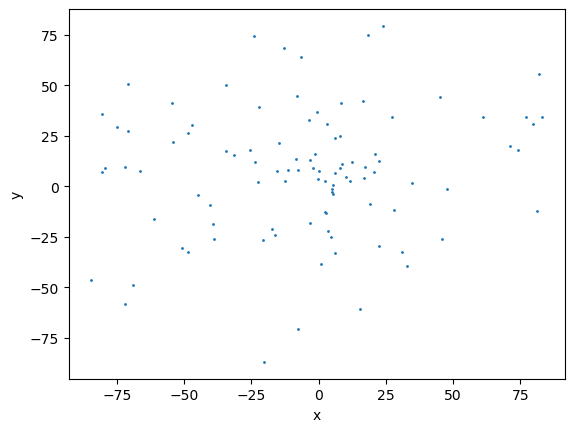

In [35]:
# plot initial positions
def plot_particles(particles):
    positions = np.array([p.position for p in particles])
    plt.scatter(positions[:, 0], positions[:, 1], s=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

plot_particles(particles)

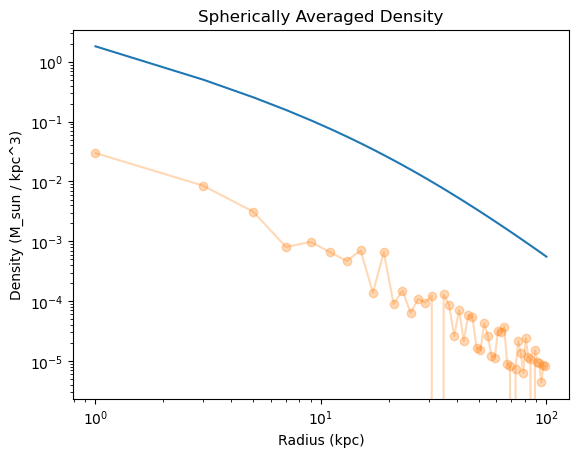

In [10]:
def spherically_averaged_density(particles, r_max, num_bins):
    """Compute spherically averaged density as a function of radius."""
    positions = np.array([p.position for p in particles])
    masses = np.array([p.mass for p in particles])
    
    # Compute the radial distance for each particle
    r = np.linalg.norm(positions, axis=1)
    
    # Define the bin edges and compute the bin volumes
    bin_edges = np.linspace(0, r_max, num_bins + 1)
    bin_volumes = 4/3 * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
    
    # Compute the density in each bin
    density = np.zeros(num_bins)
    for i in range(num_bins):
        in_bin = (r >= bin_edges[i]) & (r < bin_edges[i+1])
        density[i] = np.sum(masses[in_bin]) / bin_volumes[i]
    
    # Compute the bin centers
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    return bin_centers, density

def plot_spherically_averaged_density(particles, r_max=10, num_bins=50):
    """Plot the spherically averaged density as a function of radius."""
    bin_centers, density = spherically_averaged_density(particles, r_max, num_bins)

    # add nfw density profile
    r = np.linspace(1, r_max, num_bins)
    nfw = nfw_density(r)
    plt.plot(r, nfw, label='NFW Profile')
    plt.plot(bin_centers, density, 'o-', alpha=0.3)
    plt.xlabel('Radius (kpc)')
    plt.ylabel('Density (M_sun / kpc^3)')
    plt.yscale('log')
    plt.xscale('log')
    plt.title('Spherically Averaged Density')
    plt.show()

# Example usage
# particles = initialize_particles(1000)
plot_spherically_averaged_density(particles, r_max=100, num_bins=50)

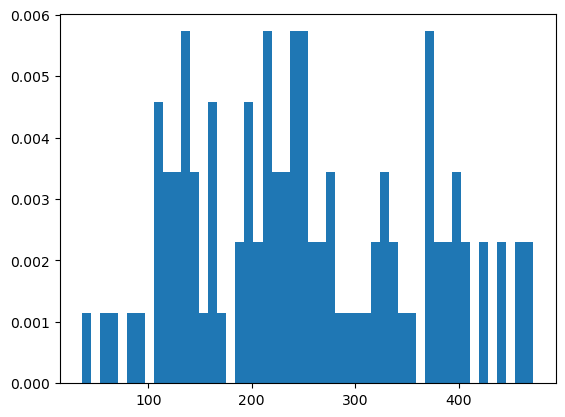

In [36]:
# plot the velocities 
velocities = np.array([p.velocity for p in particles])
speeds = np.linalg.norm(velocities, axis=1)
plt.hist(speeds, bins=50, density=True)
plt.show()

(array([1.10825091e-04, 2.88145236e-04, 6.72338884e-04, 7.60998956e-04,
        1.08608589e-03, 1.49244455e-03, 1.74364809e-03, 2.06873503e-03,
        2.40859864e-03, 2.77801561e-03, 3.41341279e-03, 3.46513117e-03,
        3.62767464e-03, 3.61289796e-03, 4.14485839e-03, 3.81977146e-03,
        3.94537323e-03, 3.47251951e-03, 3.42080113e-03, 3.10310254e-03,
        3.19915095e-03, 2.65980218e-03, 2.53420041e-03, 2.29038521e-03,
        2.33471524e-03, 1.82491983e-03, 1.64759968e-03, 1.42594950e-03,
        1.25601769e-03, 1.01959083e-03, 8.79212386e-04, 6.50173865e-04,
        5.17183757e-04, 5.17183757e-04, 3.54640290e-04, 3.98970327e-04,
        2.06873503e-04, 1.40378448e-04, 1.18213430e-04, 1.40378448e-04,
        6.64950544e-05, 8.12717332e-05, 3.69416969e-05, 5.91067150e-05,
        1.47766788e-05, 3.69416969e-05, 0.00000000e+00, 1.47766788e-05,
        7.38833938e-06, 1.47766788e-05]),
 array([ 15.37886003,  28.9137012 ,  42.44854236,  55.98338353,
         69.5182247 ,  83.0530

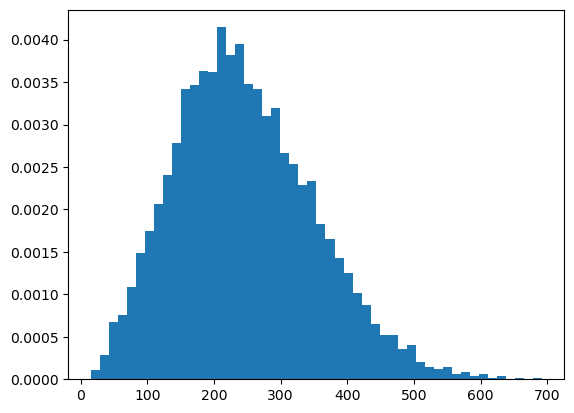

In [139]:
# plot the distribution from the maxwell_boltzmann_samples function 
plt.hist(maxwell_boltzmann_samples(1.0, 220.0, num_samples=10000), bins=50, density=True)

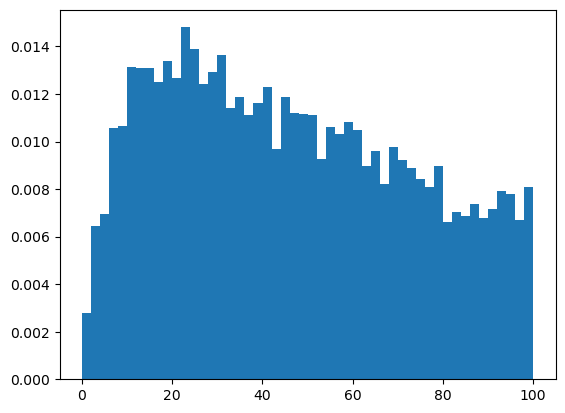

In [143]:
# plot nfw samples 
plt.hist(nfw_samples(rmax=100, num_samples=10000), bins=50, density=True)

plt.show()

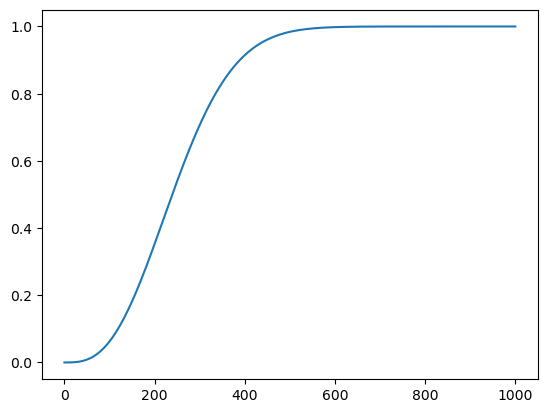

In [120]:
# plot the CDF of the maxwell boltzmann distribution
v, cdf = compute_maxwell_boltzmann_cdf()
plt.plot(v, cdf)

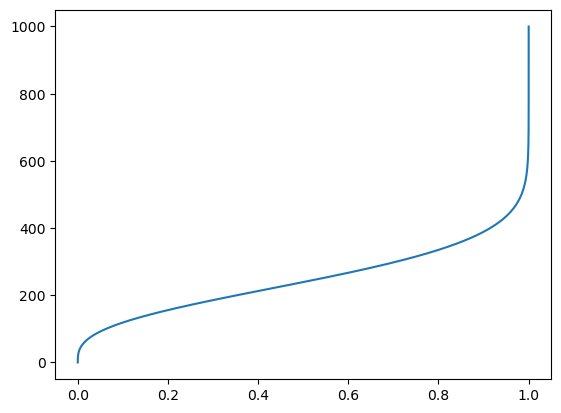

In [121]:
# plot the inverted cdf
# Invert the CDF using interpolation

inverse_cdf = invert_cdf_vel(v, cdf)
plt.plot(cdf, inverse_cdf(cdf))

(array([8.17080497e-05, 0.00000000e+00, 6.53664398e-04, 5.71956348e-04,
        8.98788547e-04, 1.22562075e-03, 1.79757709e-03, 1.87928514e-03,
        1.96099319e-03, 2.36953344e-03, 2.45124149e-03, 2.69636564e-03,
        2.85978174e-03, 3.26832199e-03, 3.59515419e-03, 4.08540249e-03,
        4.41223468e-03, 3.75857029e-03, 2.94148979e-03, 3.92198639e-03,
        4.08540249e-03, 3.75857029e-03, 4.41223468e-03, 2.45124149e-03,
        2.94148979e-03, 2.77807369e-03, 2.28782539e-03, 2.36953344e-03,
        2.04270124e-03, 1.14391270e-03, 1.14391270e-03, 1.55245294e-03,
        1.06220465e-03, 3.26832199e-04, 4.08540249e-04, 8.17080497e-04,
        5.71956348e-04, 2.45124149e-04, 4.90248298e-04, 8.17080497e-05,
        4.08540249e-04, 2.45124149e-04, 8.17080497e-05, 0.00000000e+00,
        1.63416099e-04, 0.00000000e+00, 0.00000000e+00, 8.17080497e-05,
        1.63416099e-04, 1.63416099e-04]),
 array([ 13.64897205,  25.88766828,  38.12636451,  50.36506074,
         62.60375697,  74.8424

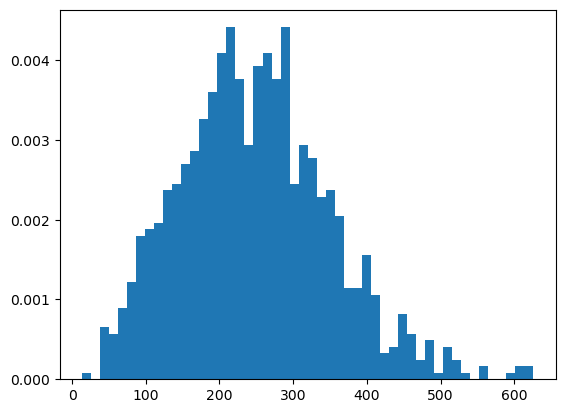

In [122]:
# draw smaples from inverse cdf and plot
samples = inverse_cdf(np.random.uniform(0, 1, 1000))
plt.hist(samples, bins=50, density=True)

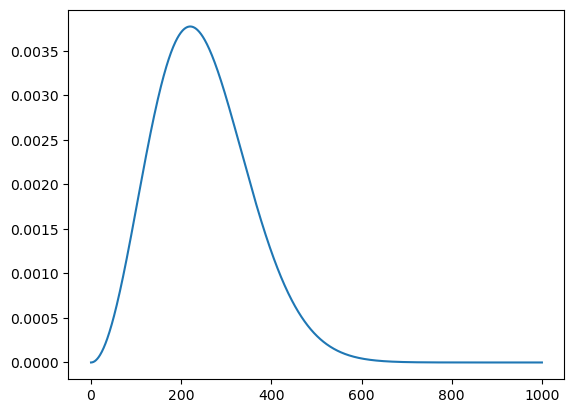

In [115]:
def maxwell_boltzmann_pdf(v, mass=1.0, peak_speed=220.0):
    temperature = mass * peak_speed**2 / (2 * kB)
    prefactor = (mass / (2 * np.pi * kB * temperature)) ** (3/2)
    return prefactor * np.exp(-(mass * v**2) / (2 * kB * temperature)) * 4 * np.pi * v**2

# plot the maxwell-boltzmann pdf 
v = np.linspace(0, 1000, 1000)
pdf = maxwell_boltzmann_pdf(v)
plt.plot(v, pdf, label='Maxwell-Boltzmann PDF')

# Forces

In [37]:
# softening_length = 0.01
def compute_forces(particles, epsilon=0.01):
    def softening_kernel(r, epsilon):
        r_squared = np.dot(r, r)
        return (r_squared + (3/2) * epsilon**2) / (r_squared + epsilon**2)**(3/2)

    # def softening_kernel(r, epsilon):
    #     r_norm = np.linalg.norm(r)
    #     return 1 / (r_norm**2 + epsilon**2)**(3/2)

    for particle in particles:
        particle.force[:] = 0.0  # Reset force to zero

    for i, p1 in enumerate(particles):
        for j, p2 in enumerate(particles):
            if i != j:
                r = p2.position - p1.position
                distance = np.linalg.norm(r)
                if distance > 0:  # Avoid division by zero
                    force_magnitude =  G * p1.mass * p2.mass * softening_kernel(r, epsilon)
                    force_vector = force_magnitude * r
                    p1.force += force_vector

def update_accelerations(particles):
    for particle in particles:
        particle.acceleration = particle.force / particle.mass

def handle_collisions(particles, dt, epsilon=0.1):
    for i, p1 in enumerate(particles):
        for j, p2 in enumerate(particles):
            if i < j:  # Avoid double checking pairs
                r = p2.position - p1.position
                distance = np.linalg.norm(r)
                if distance < epsilon:  # Check if particles are close enough to collide
                    # relative_velocity = np.linalg.norm(p1.velocity - p2.velocity)
                    probability = p1.scattering_probability(p2)
                    if random.random() < probability * dt:  # Determine if collision occurs
                        print(f'Collision between particles {i} and {j}')
                        # Elastic collision conserving momentum and energy
                        m1, m2 = p1.mass, p2.mass
                        v1, v2 = p1.velocity, p2.velocity
                        r1, r2 = p1.position, p2.position
                        r_rel = r1 - r2
                        v_rel = v1 - v2
                        r_rel_norm = np.linalg.norm(r_rel)**2
                        if r_rel_norm == 0:
                            continue
                        # Calculate new velocities after collision
                        v1_new = v1 - (2 * m2 / (m1 + m2)) * (np.dot(v_rel, r_rel) / r_rel_norm) * r_rel
                        v2_new = v2 - (2 * m1 / (m1 + m2)) * (np.dot(-v_rel, -r_rel) / r_rel_norm) * (-r_rel)
                        # Update particle velocities
                        p1.velocity, p2.velocity = v1_new, v2_new

compute_forces(particles)
update_accelerations(particles)

In [38]:
def velocity_verlet(particles, dt):
    # Update positions
    for particle in particles:
        particle.position += particle.velocity * dt + 0.5 * particle.acceleration * dt**2
    
    # Compute new forces
    compute_forces(particles)
    update_accelerations(particles)
    
    # Update velocities
    for particle in particles:
        particle.velocity += 0.5 * (particle.acceleration + particle.force / particle.mass) * dt

Collision between particles 8 and 73


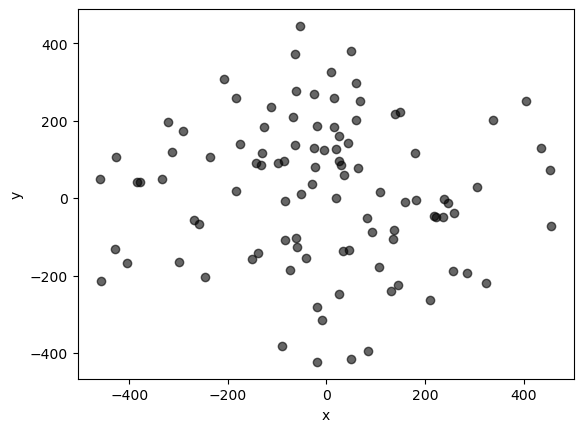

In [39]:
# Time step
dt = 0.01

# Number of steps
num_steps = 100

# Arrays to store positions for plotting
positions = []

# Main loop
for step in range(num_steps):
    positions.append([p.position.copy() for p in particles])
    velocity_verlet(particles, dt)
    handle_collisions(particles, dt)

# Convert positions to numpy array for easier plotting
positions = np.array(positions)

# Plotting the trajectories
for i, particle in enumerate(particles):
    plt.scatter(positions[-1, i, 0], positions[-1, i, 1], color='k', alpha=0.6)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Animations

/var/folders/71/rd8s6g0x52sd1l6wnf9_z6_r0000gn/T/ipykernel_43042/814823121.py:20: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  scatter.set_data(positions[frame, i, 0], positions[frame, i, 1])


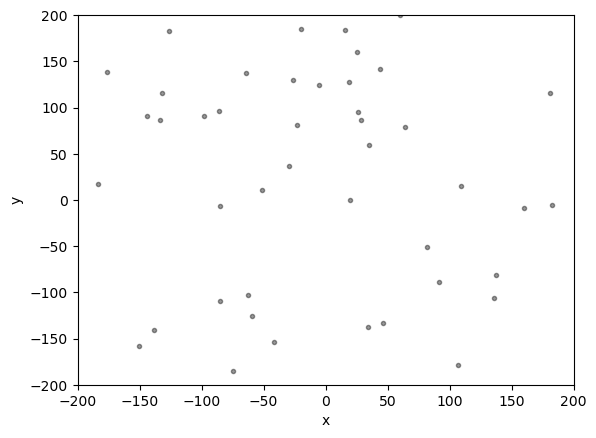

In [40]:
# Create a figure and axis for the animation
fig, ax = plt.subplots()
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_xlabel('x')
ax.set_ylabel('y')

# Initialize scatter plot for particles
scatters = [ax.plot([], [], 'o', color='k', alpha=0.4, ms=3, label=f'Particle {i+1}')[0] for i in range(len(particles))]

# Initialization function for the animation
def init():
    for scatter in scatters:
        scatter.set_data([], [])
    return scatters

# Animation function which updates the scatter plot
def update(frame):
    for i, scatter in enumerate(scatters):
        scatter.set_data(positions[frame, i, 0], positions[frame, i, 1])    
    return scatters

# Create the animation object
ani = FuncAnimation(fig, update, frames=range(0, num_steps, 1), init_func=init, blit=True)

# Save the animation as a GIF
ani.save('slow.gif', writer='pillow', fps=30)

# Display the animation (optional, remove if running in a non-interactive environment)

plt.show()